# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 37

**Author 1 (sciper):** Elias De Smijter (366670)  
**Author 2 (sciper):** Félicie Alice Agnès Marie Giraud-Sauveur (284220)   
**Author 3 (sciper):** Cyril Felix Monette (299554)

**Release date:** 24.03.2023  
**Due date:** 07.04.2023 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library. In the `lab-02-data` folder, you will find 28x28 grey-scale pictures of handwritten "0", "1", "2" and "3".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

### 0.1.Data visualization

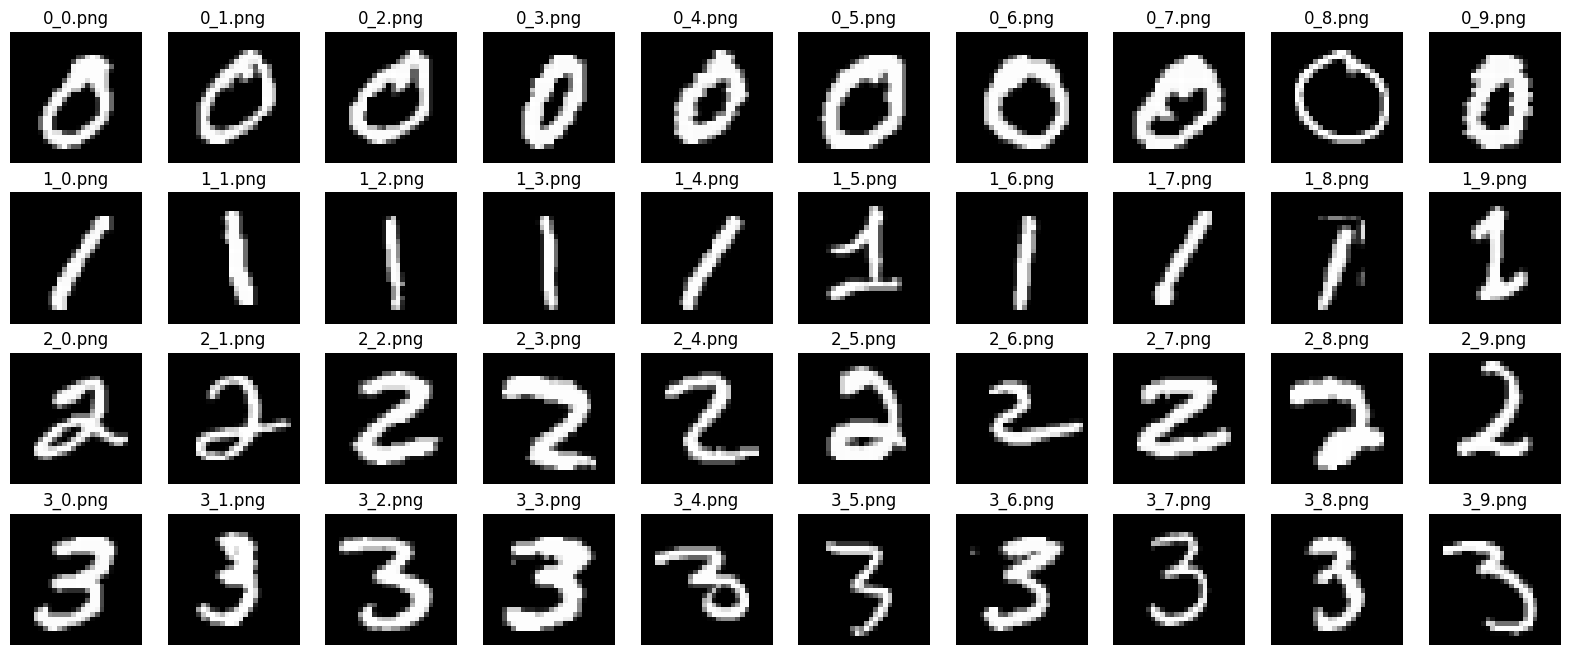

In [28]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
# Load digits data

# Zero images arrays
zeros_im, zeros_names = load(data_part1, digit='0')
# Ones images arrays
ones_im, ones_names = load(data_part1, digit='1')
# Twos images arrays
twos_im, twos_names = load(data_part2, digit='2')
# Threes images arrays
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 8))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

---
## Part 1 - contour based descriptors (18 pts)

In this part you will use images of "0"s and "1"s.

**Objectives overview**: Fourier Descriptors


**1)** *Preprocess*: Select ONLY "0" and "1" images and apply suitable preprocessing. Show a plot with the preprocessed data and give arguments on the chosen techniques. (**2 pts**)


**2)** *Get descriptors*: Find the contours and get the Fourier descriptors in complex definition. *Note*: The contours arrays should contain a finite number (N-> self-chosen) of equi-distant points for each image (hint: interpolation). In the case of the "0" contours, just keep the outermost contour. Discuss the necessity of this format. (**4 pts**)
    
    
**3)** *Study effect of descriptors* : Show the contour-reconstruction of the digits using different amount of descriptors (both for ONE "0" image and ONE "1" image)
- Make 5 plots, reconstructing the digits' countours using different amounts of descriptors. (e.g. reconstruct the contour using the only the 1st fourier descriptor, reconstruct using the first two fourier descriptors,  using the first three ...)  
- **Hint**: check scipy fft, ifft, and fftfreq functions (see [link](https://docs.scipy.org/doc/scipy/tutorial/fft.html)) and pay attention on the ordering, observing which coefficients correspond to positive/negative frequencies of components and how you choose your low frequency subsets . 
- **Extra hint** To reconstruct the contour, copy the original vector of the fourier descriptors, keep the positive an negative frequencies you will use, and set to 0 the rest. (e.g. If you want to reconstruc the image with the first _three fourier descriptors_, keep the first _three positive frecuencies_ and their respective _three negative frequencies_ (see positive and negative bin freque
    frequencies [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ). 
- Discuss about your findings. (**4 pts**)
    
        
**4)** *Clustering*: For each image containing a "0" or a "1", using the fourier descriptors, extract a 2-dimensional feature vector (using the THE POSITIVE bin frequencies from fftfreq, see [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ) and plot all of them on a 2D graph. Did you obtain a plot where the vectors of the "0"'s nicely cluster in one part of the plane and those of the "1"'s in the other? If yes, explain why. (**2 pts**)
    
    
**5)** *Show translation, rotation and scale invariance*
- Firstly, discuss which descriptors, or which part of the descriptors are affected by each transformation. For each transformation define (write in words) an operation which will be applied to the descriptor arrays, such that they will be invariant to (not affected by) the specific transformation anymore. After finding the necessary operations, define a function that will make the Fourier descriptors invariant to all the transformations, altogether.(**3 pts**) 
- Secondly, show that if you are using descriptors invariant to transformations, you still obtain 2 nicely defined clusters for the 2 categories of numbers, under transformations applied. (You need to define custom functions for each transformation, apply them on images, and compare the obtained invariant descriptors). Discuss your findings. (**3 pts**)

### 1. Fourier Descriptors

### 1.1. Preprocess and visualization (2 pts)

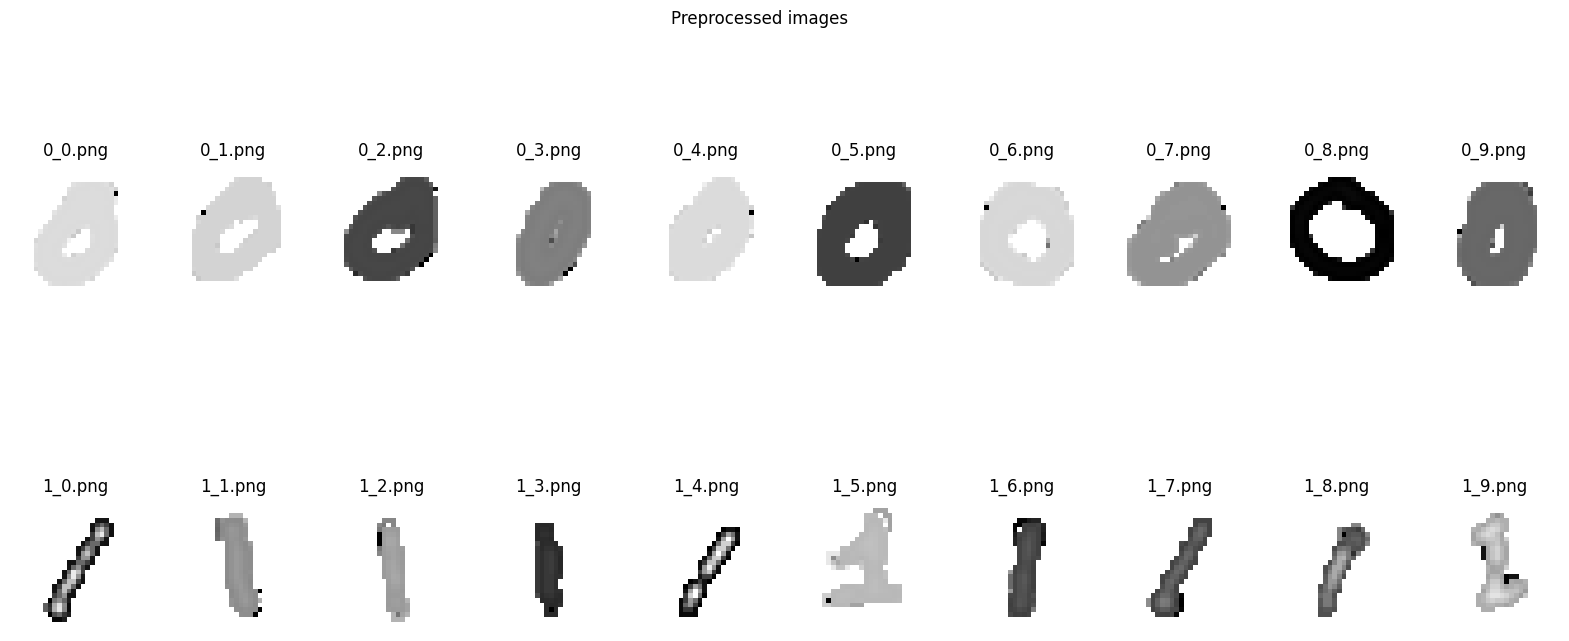

In [60]:
from scipy.signal import wiener
from skimage.filters import median
import cv2
from skimage.morphology import remove_small_objects

# Pre-processing: Wiener filtering

    # lists below with your preprocessed images of "0"s and "1"s
zeros = []
ones = []

    # pre-process, fill lists and plot
fig, axes = plt.subplots(2, len(zeros_im), figsize=(20, 8))

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im_preprocessed = wiener(median(im.copy()),3)
    zeros.append(im_preprocessed)
    ax.imshow(im_preprocessed, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im_preprocessed = wiener(remove_small_objects(cv2.convertScaleAbs(median(im.copy())), min_size=3), 3)
    ones.append(im_preprocessed)
    ax.imshow(im_preprocessed, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

fig.suptitle("Preprocessed images")
plt.show()

#### Discussion

TODO

### 1.2. Get descriptors (4 pts)

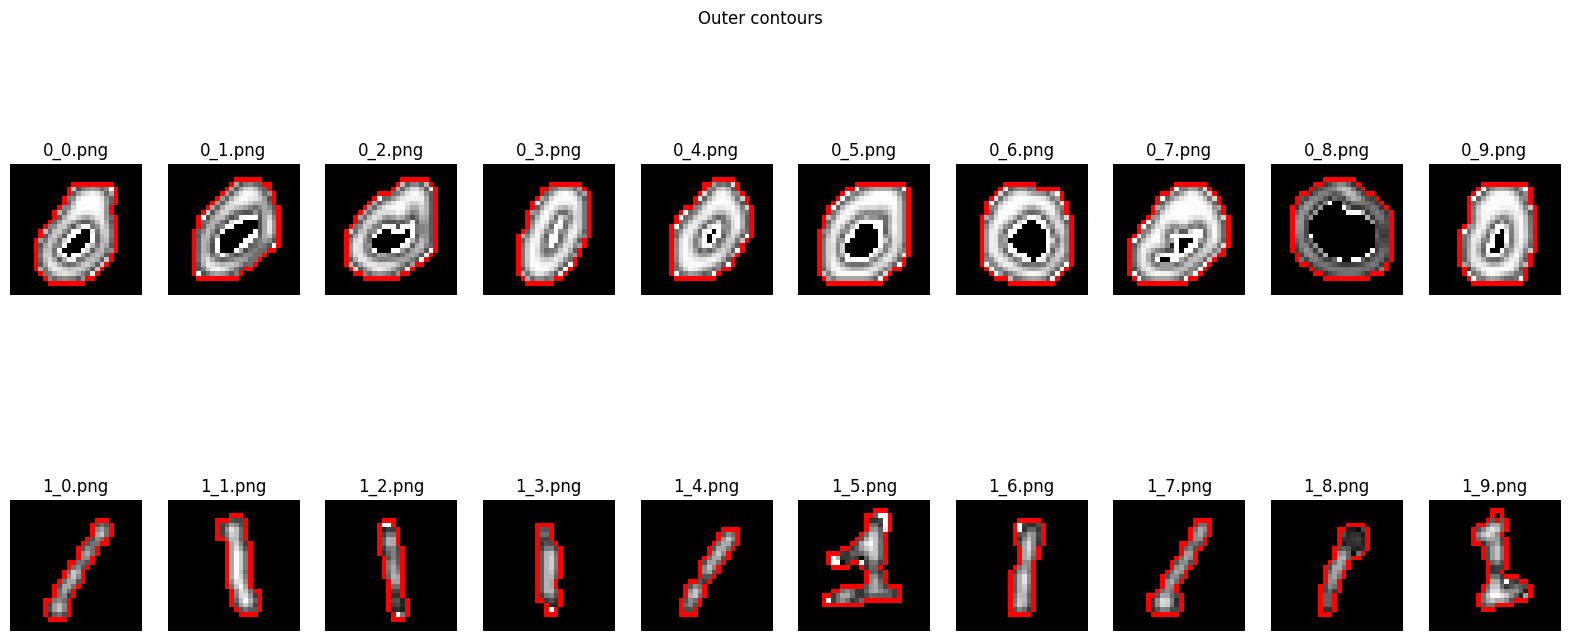

In [72]:
# Find contours

    # lists with contours
zeros_Co = []
ones_Co = []

    # Find contours, fill lists and plot
fig, axes = plt.subplots(2, len(zeros), figsize=(20, 8))

for ax, im, nm in zip(axes[0], zeros, zeros_names):
    im_contours = im.copy()
    im_contours = cv2.convertScaleAbs(im_contours)
    Co, _ = cv2.findContours(im_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    zeros_Co.append(Co)
    im_contours = cv2.cvtColor(im_contours, cv2.COLOR_GRAY2BGR)
    ax.imshow(cv2.drawContours(im_contours, Co, -1, (255, 0, 0), 1))
    ax.axis('off')
    ax.set_title(nm)  

for ax, im, nm in zip(axes[1], ones, ones_names):
    im_contours = im.copy()
    im_contours = cv2.convertScaleAbs(im_contours)
    Co, _ = cv2.findContours(im_contours, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ones_Co.append(Co)
    im_contours = cv2.cvtColor(im_contours, cv2.COLOR_GRAY2BGR)
    ax.imshow(cv2.drawContours(im_contours, Co, -1, (255, 0, 0), 1))
    ax.axis('off')
    ax.set_title(nm) 

fig.suptitle("Outer contours")
plt.show()

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/drawing.cpp:2508: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


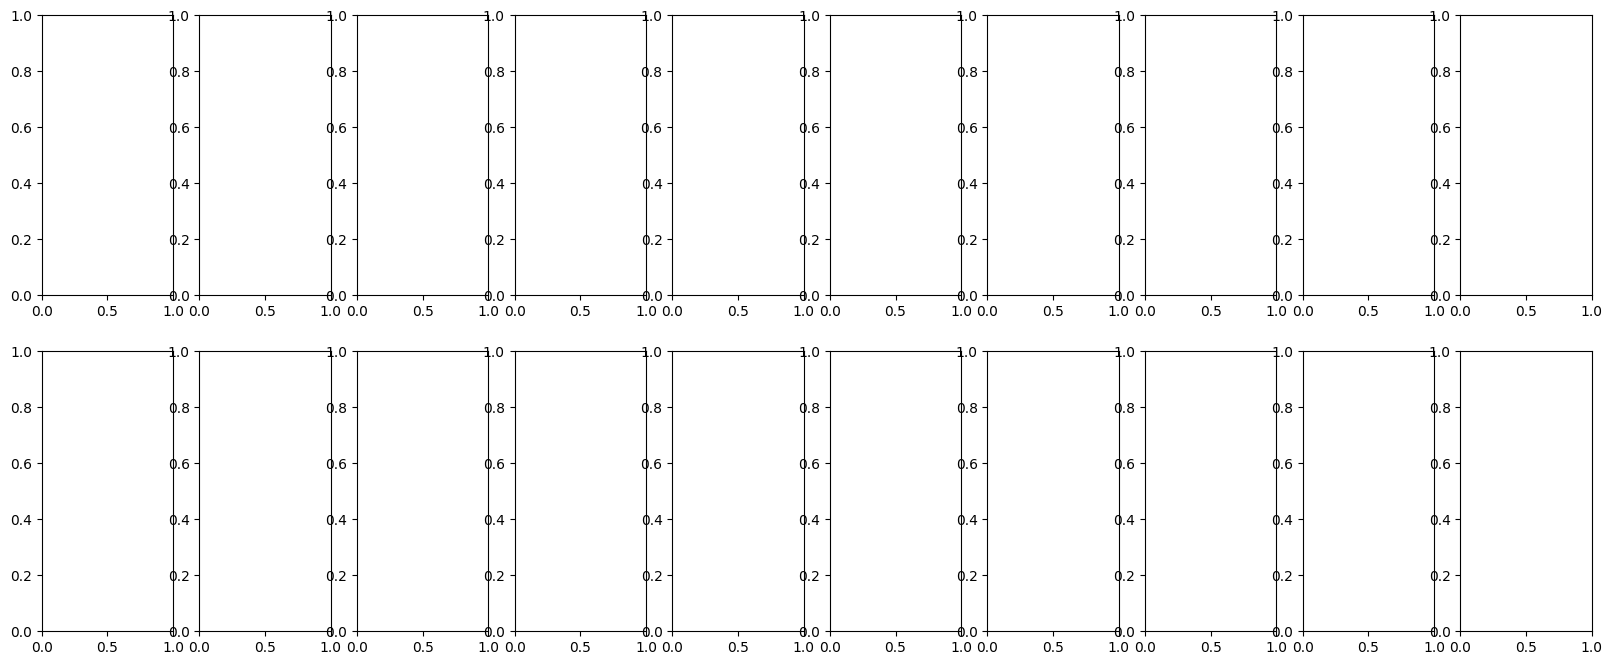

In [122]:
import numpy as np

# Interpolation

    # lists with contours
zeros_Co_interp = []
ones_Co_interp = []

    # Find contours, fill lists and plot
fig, axes = plt.subplots(2, len(zeros), figsize=(20, 8))

for i, (ax, im, nm) in enumerate(zip(axes[0], zeros, zeros_names)):
    im_interp = im.copy()
    im_interp = cv2.convertScaleAbs(im_interp)
    # interpolation
    xco = zeros_Co[i][0].T[0][0]
    xco_interp = np.interp(np.arange(len(xco)), np.arange(2*len(xco), step=2), xco)
    yco = zeros_Co[i][0].T[0][0]
    yco_interp = np.interp(np.arange(len(yco)), np.arange(2*len(yco), step=2), yco)
    # plot
    im_interp = cv2.cvtColor(im_interp, cv2.COLOR_GRAY2BGR)
    ax.imshow(cv2.drawContours(im_interp, np.array((xco_interp, yco_interp)).T, -1, (255, 0, 0), 1))
    ax.axis('off')
    ax.set_title(nm)  

for i, (ax, im, nm) in enumerate(zip(axes[0], ones, ones_names)):
    im_interp = im.copy()
    im_interp = cv2.convertScaleAbs(im_interp)
    # interpolation
    xco = zeros_Co[i][0].T[0][0]
    xco_interp = np.interp(np.arange(len(xco)), np.arange(2*len(xco), step=2), xco)
    yco = zeros_Co[i][0].T[0][0]
    yco_interp = np.interp(np.arange(len(yco)), np.arange(2*len(yco), step=2), yco)
    # plot
    im_interp = cv2.cvtColor(im_interp, cv2.COLOR_GRAY2BGR)
    ax.imshow(cv2.drawContours(im_interp, np.array((xco_interp, yco_interp)).T, -1, (255, 0, 0), 1))
    ax.axis('off')
    ax.set_title(nm) 

fig.suptitle("Outer contours")
plt.show()

In [121]:
np.array((xco_interp, yco_interp)).T

(array([[[13,  4]],
 
        [[12,  5]],
 
        [[12,  6]],
 
        [[11,  7]],
 
        [[11,  8]],
 
        [[ 9, 10]],
 
        [[ 9, 11]],
 
        [[ 6, 14]],
 
        [[ 6, 15]],
 
        [[ 5, 16]],
 
        [[ 5, 22]],
 
        [[ 8, 25]],
 
        [[15, 25]],
 
        [[16, 24]],
 
        [[17, 24]],
 
        [[21, 20]],
 
        [[21, 19]],
 
        [[22, 18]],
 
        [[22, 11]],
 
        [[21, 10]],
 
        [[21,  9]],
 
        [[22,  8]],
 
        [[22,  5]],
 
        [[21,  4]]], dtype=int32),)

In [124]:


# Function that takes as input an image and returns a set of descriptors. 
# You may use other custom helper functions to break the code into useful chuncks.

def get_descriptors(img):
    descriptors = []
    # TODO
    
    return descriptors

# Check first 10 descriptors of a test image (just to check that your pipeline works well)
print(get_descriptors(zeros_im[0])[:10])

[]


In [105]:
import scipy.interpolate as test
test.UnivariateSpline(zeros_Co[0][0].T[0][0], zeros_Co[0][0].T[1][0])

ValueError: x must be increasing if s > 0

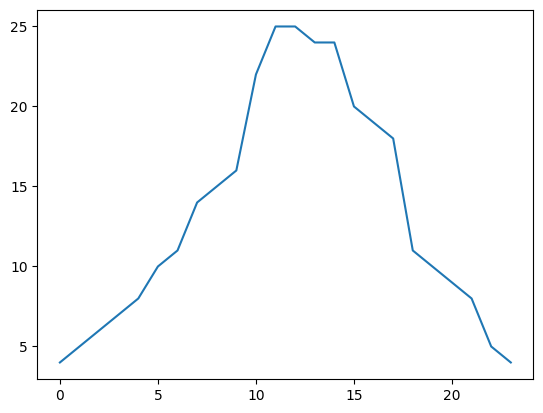

In [107]:
plt.plot(zeros_Co[0][0].T[1][0])

In [112]:
zeros_Co[0][0].T[0][0]

array([13, 12, 12, 11, 11,  9,  9,  6,  6,  5,  5,  8, 15, 16, 17, 21, 21,
       22, 22, 21, 21, 22, 22, 21], dtype=int32)

#### Discussion

TODO

### 1.3. Study effect of descriptors (6 pts)

In [ ]:
# Define increasing set sizes of the descriptors. You can also change these numbers.
descr_set_sizes = [1, 2, 5, 10, 20]

# Define images for which you will show the recovery. You can also change the indexes.
zero = zeros_im[0]
one = ones_im[0]

In [ ]:
# TODO

In [ ]:
# On each of the 5 plots you will show the recovery for a "0" and a "1" (used the same axis for both a "0" and a "1").
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Plot recovery for a zero image
for i in range(0,  5):
    # TODO
    axes[i].# TODO

# Plot recovery for a one image
for i in range(0,  5):
     # TODO
    axes[i].# TODO

fig.suptitle("Recovery of the contours")
plt.show()

#### Discussion

TODO

### 1.4 Clustering (2 pts)

In [ ]:
# TODO

In [ ]:
# TODO: You should fill the lists below, with your features

# First feature for all "0"s
zeros_f1 = []
# Second feature for all "0"s
zeros_f2 = []
# Fist feature for all "1"s
ones_f1 = []
# Second feature for all "1"s
ones_f2 = []

# Plot features for all images
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(zeros_f1, zeros_f2, color='r', label='zeros')
ax.scatter(ones_f1, ones_f2, color='b', label='ones')
ax.legend(loc='best')
plt.title("Features based on 2 Fourier descriptors")
plt.show()

#### Discussion


TODO

### 1.5 Transformation invariance (6 pts)

#### Preliminary discussion

TODO

#### Implementation

In [ ]:
# TODO: Implement a function that takes as input an image and outputs 
# a set of features invariant to scale, rotation and translation, according to function boolean parameters.
# You may use your functions defined in section 1.B.

def get_invariant_features(img, inv_to_rotation=False, inv_to_translation=False, inv_to_scale=False):
    pass

In [ ]:
# Define custom rotation function. You may add other parameters to the function.
def random_rotate(img):
    # TODO
    pass

# Define custom rotation function. You may add other parameters to the function.
def random_translate(img):
    # TODO
    pass
    
# Define custom rotation function. You may add other parameters to the function.
def random_scale(img):
    # TODO
    pass

In [ ]:
# We will define 4 sets of new images below

# TODO: Apply only rotation for each "0" and "1" and store results below
rotated_images_zeros = []
rotated_images_ones = []

# TODO: Apply only translation for each "0" and "1" and store results below
translated_images_zeros = []
translated_images_ones = []

# TODO: Apply only scaling for each "0" and "1" and store results below
scaled_images_zeros = []
scaled_images_ones = []

# TODO: Apply all 3 transformations sequentially, in your custom order, for each "0" and "1" and store results below
transformed_images_zeros = []
transformed_images_ones = []

In [ ]:
# For each of the 4 sets of "0"s and "1"s above, you should find the invaiant features
# and make a plot (similar to section 1.4) - 4 plots in total!
# Use a proper labeling/legend for the plots!


# TODO

#### Discussion

TODO

## PART 2 - region based descriptors (10 pts)

In this part, you will use the "2"s and "3"s images.

**Objectives overview**:

**1)** *Cluster on compacity*: Based on custom definitions of perimeter and area for each image of "2" and "3" (preprocessed - by you), make a 2D plot with 2-dimensional feature vectors, similar to section 1.4. After that, define the compacity feature for each "2"s and "3"s image. Are you still able to obtain a 1D plot with values clustered in 2 well-defined regions? Discuss your findings. (**6 pts**).

**2)** *Additional method*: Choose one more region-based method (from the course or your own sources - internet allowed) and redo the 1D plot in section 2.1 (or 2D plot, depending on your choosing). Explain your method and your findings. (**4 pts**)

### 2.3. Cluster on compacity (6 pts)

In [ ]:
# TODO

In [ ]:
# TODO: Fill the arrays below with the perimeter and area as features for "2"s and "3"s images
twos_f1 = []
twos_f2 = []
threes_f1 = []
threes_f2 = []

# Plot features for all images
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(twos_f1, twos_f2, color='r', label='twos')
ax.scatter(threes_f1, threes_f2, color='b', label='threes')
ax.legend(loc='best')
plt.title("Features based on perimeter and area")
plt.show()

In [ ]:
# TODO: Make the 1D plot of the compacity

####  Discussion

TODO

### 2.2. Additional method (4 pts)

In [ ]:
# TODO

#### Discussion

TODO